In [7]:
%reload_ext autoreload
%autoreload 2

import warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn


import numpy as np
from pytz import timezone

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', }
import scienceplots

import pandas as pd
pd.set_option('display.max_rows', 128)
pd.set_option('display.max_columns', 128)

plt.rcdefaults()
plt.style.use(['science', 'ieee', 'no-latex'])

In [8]:
def monthly_plot(data: pd.DataFrame, key:str, month:int, year:int, ax, vmin:float=None, vmax:float=None):
    data = data[(data.index.year == year) & (data.index.month == month)]

    array = np.full(shape=(32, 24), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.day, ts.hour] = item[key]

    ax.imshow(array.T, cmap='magma', vmin=vmin, vmax=vmax, interpolation='none', aspect='auto')
    #ax.set_xlim(0.5, 31.5)

    ax.grid(False)

    # Invert the vertical axis
    #ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # Remove all spines
    ax.set_frame_on(False)


def weekly_plot(daily_data: pd.DataFrame, key: str, year:int, ax):
    data = daily_data

    assert isinstance(data.index, pd.DatetimeIndex)
    new_index = pd.date_range(start=f'{data.index.year.min()}-01-01', end=f'{data.index.year.max()+1}-01-01', freq='1D', tz=data.index.tz)
    data = data.reindex(new_index)

    data = data[(data.index.year == year)]

    # Lets figure out the size of array
    n_weeks = data.index.isocalendar().week.unique().max() + 1
    n_days = 7

    # Sorry. I couldn't find more efficient way to do it.
    array = np.full(shape=(n_weeks, n_days), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.week, ts.dayofweek] = item[key]

    ax.imshow(array.T, cmap='magma', interpolation='none')

    ax.set_xlim(0.5, n_weeks)

    ax.grid(False)

    weekdays = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
    ax.set_yticks(range(7), weekdays)

    ax.set_xlabel('week number')

    # # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # # Remove all spines
    ax.set_frame_on(False)

In [9]:
df = pd.read_parquet('../../data/lerta-dataset-hourly.parquet')
#df.tail(3).T

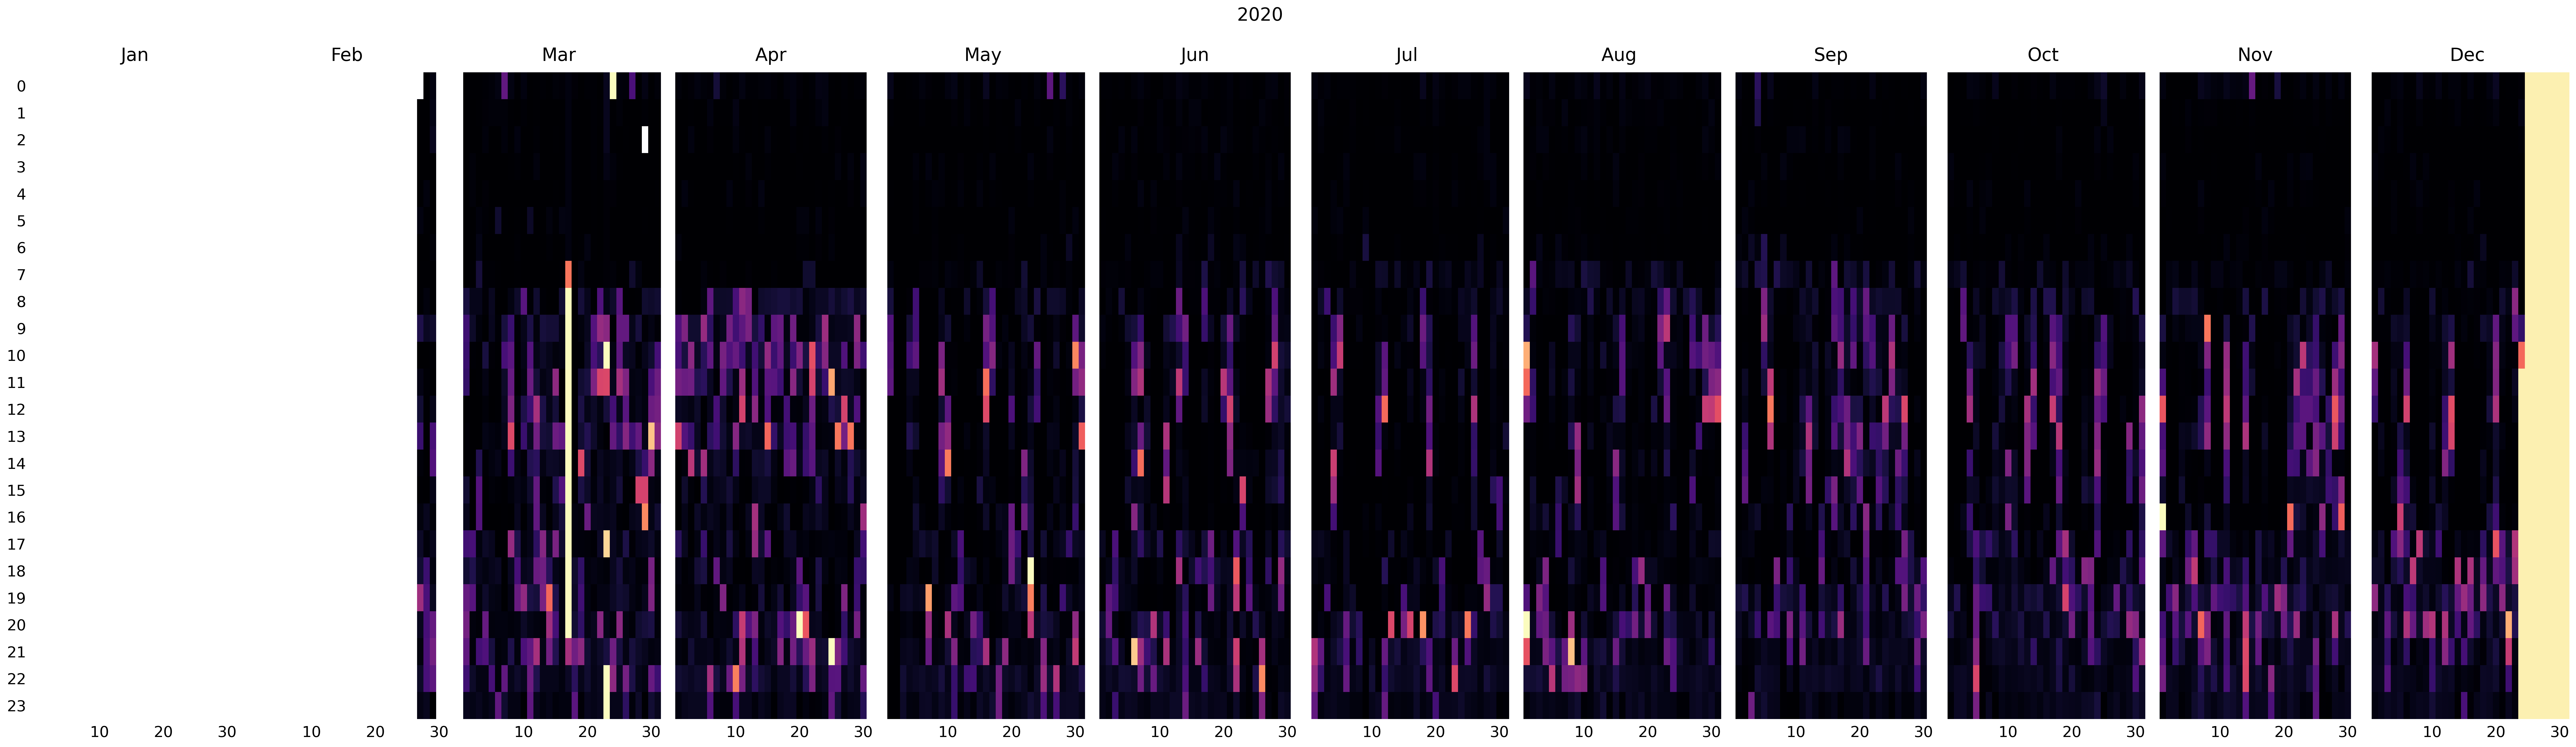

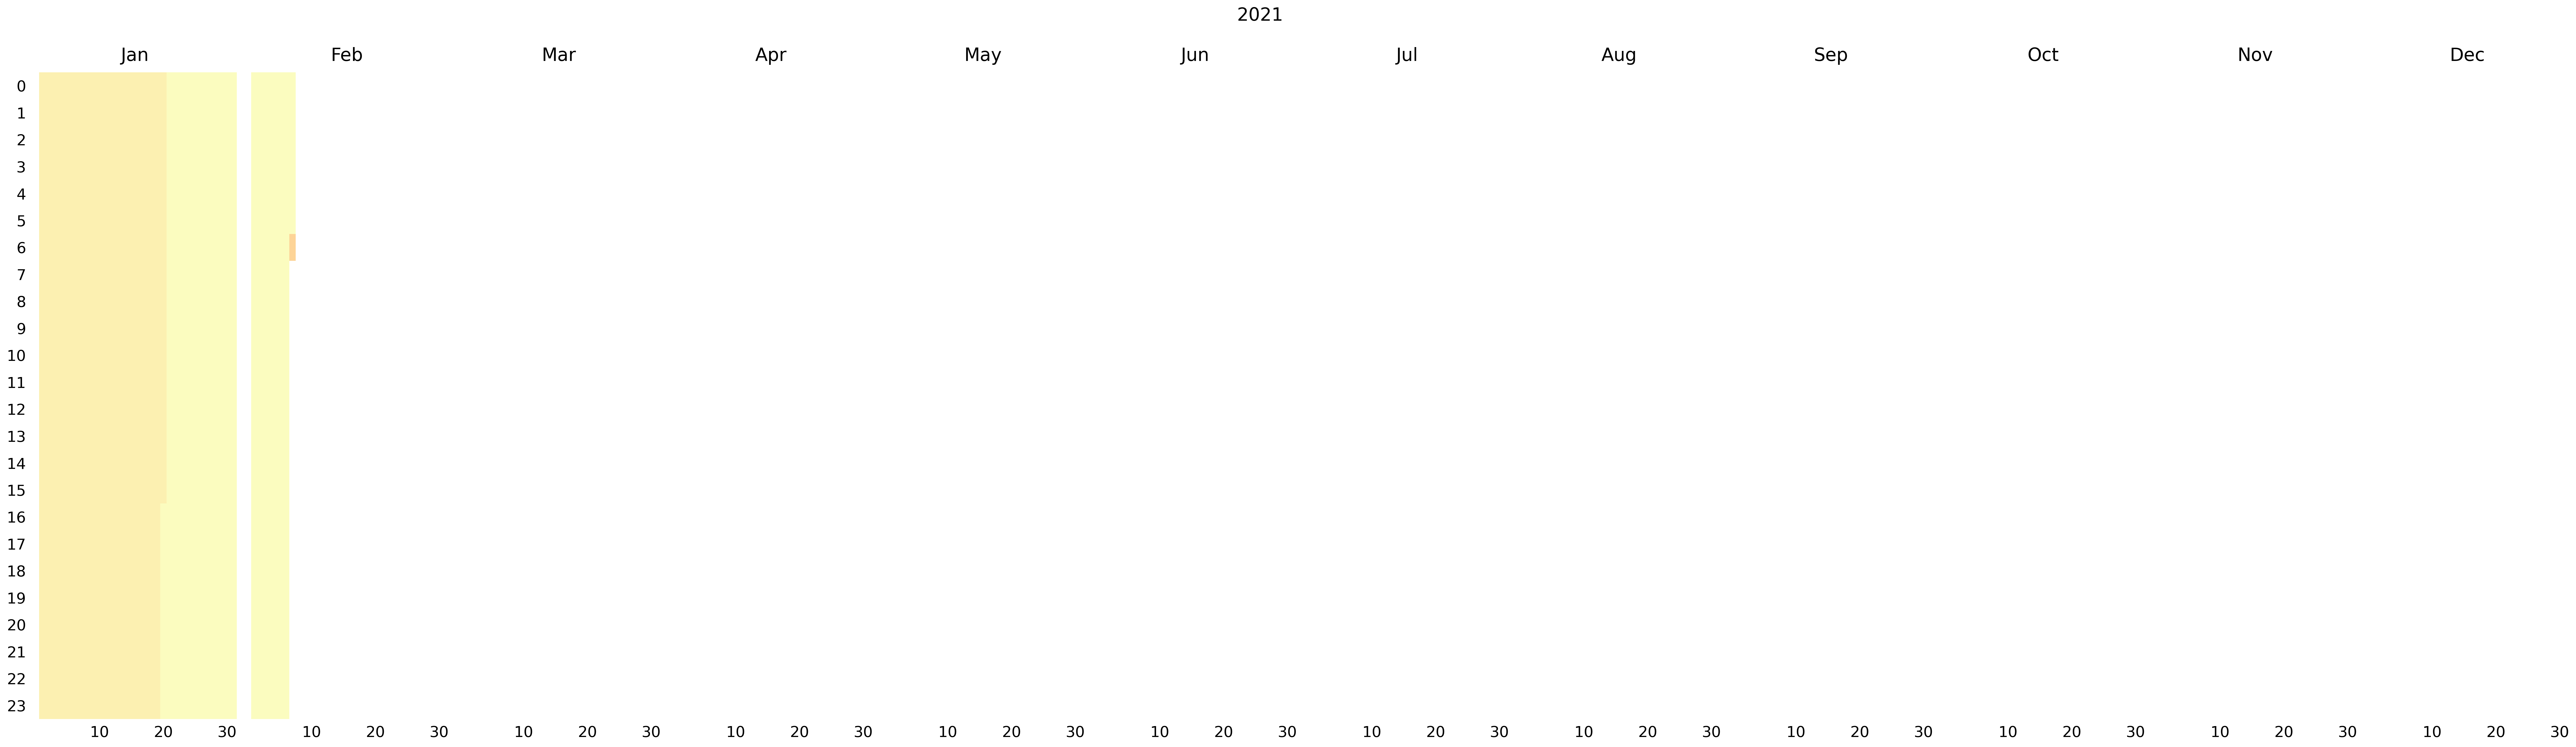

In [13]:
key = 'energy'

view = df.copy()
view = view[view.location_id == 1]
view = view.set_index('timestamp').sort_index()
view = view[[key]].resample('1H').sum()
#view = view.tz_convert(None) # remove TZ info (just for the sake of plotting)

#print(view.tail(5).T)

vmin, vmax = view[key].quantile(0.1), view[key].quantile(0.99)

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

for i, year in enumerate(view.index.year.unique()):
    fig, axes = plt.subplots(ncols=12, figsize=(20, 6), sharey=True)

    fig.suptitle(year)
    for j, month in enumerate(range(1, 13)):
        monthly_plot(view, key, month, year, axes[j], vmin, vmax)

        axes[j].set_title(months[j])

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

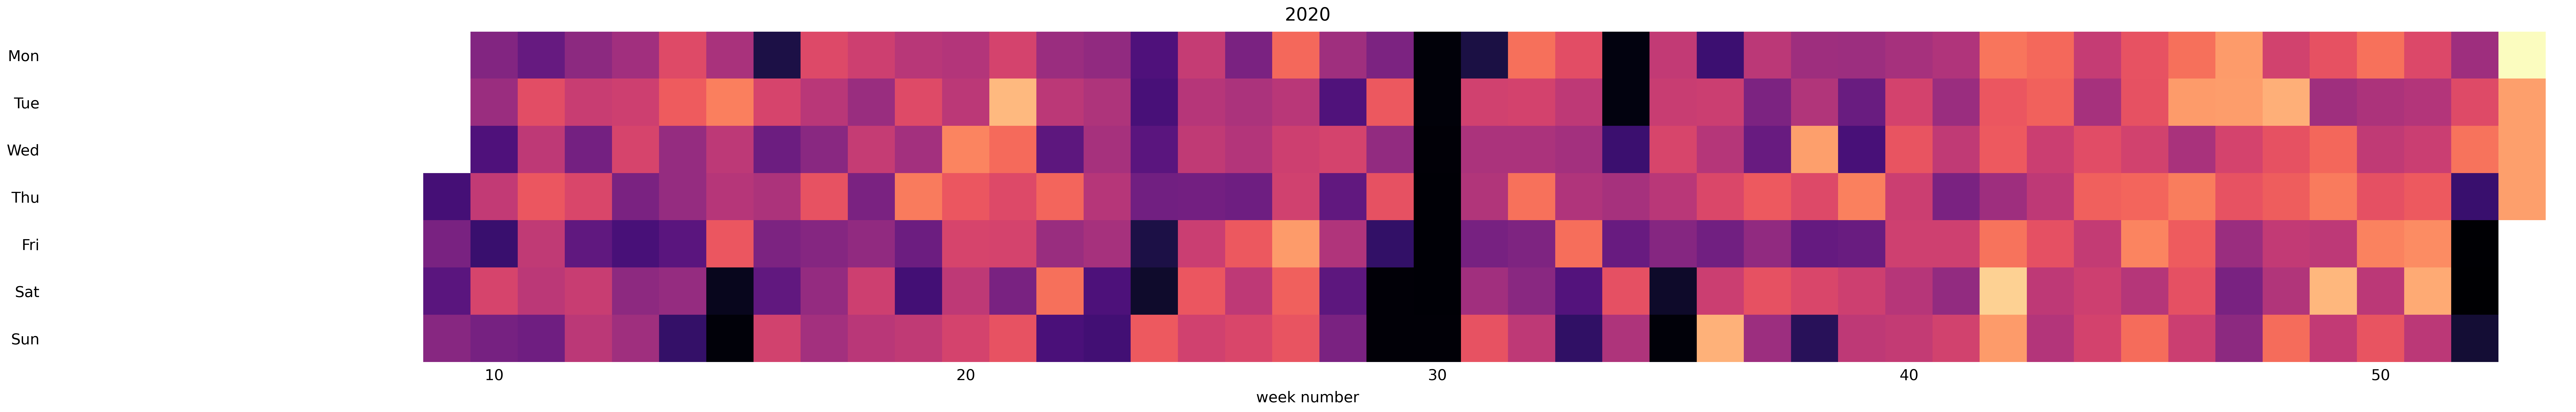

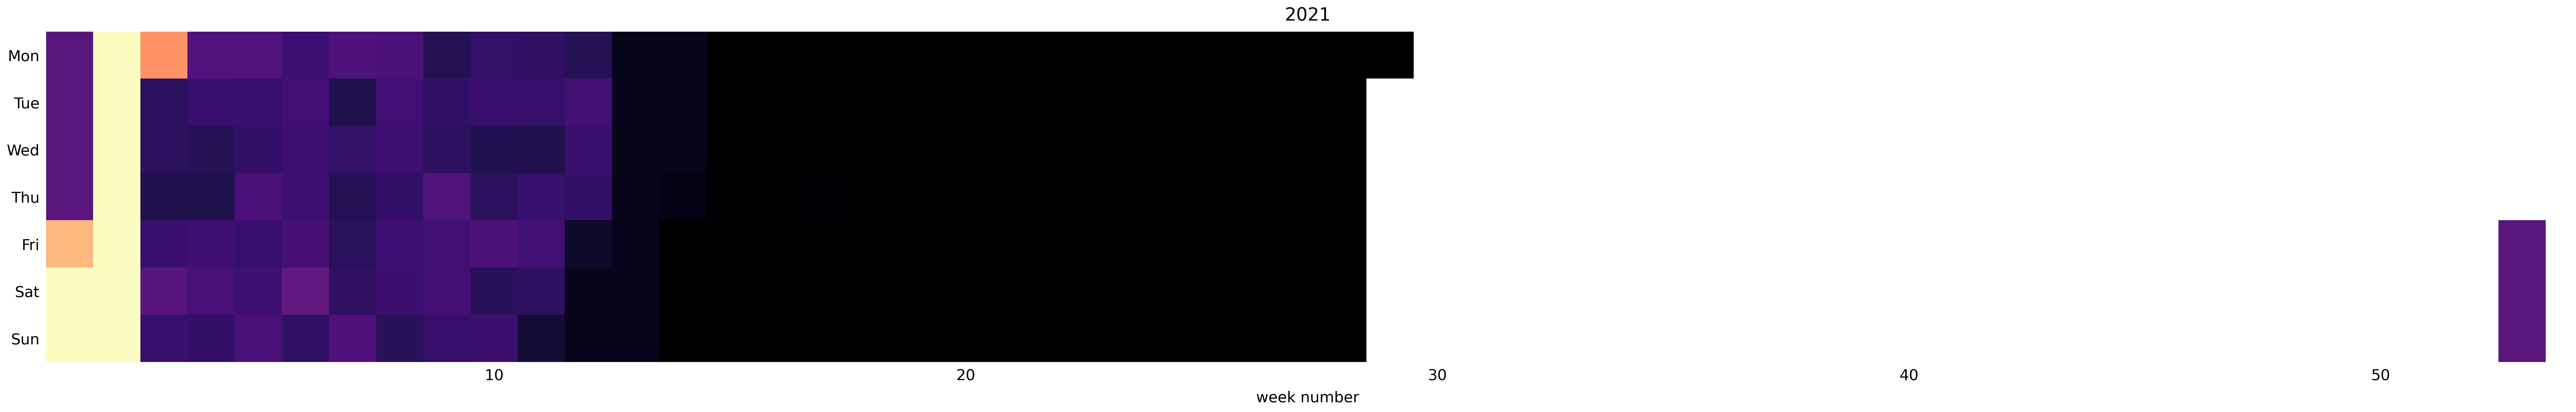

In [8]:
key = 'energy'
view = df[df.location_id == 3]
years = view.timestamp.dt.year.unique()

# Fix this two lines to your needs. You must end up with DateTimeIndex and value with daily sampling
view = view.set_index('timestamp')
view = view[[key]].resample('1D').sum()


for i, year in enumerate(years):
    fig, axes = plt.subplots(figsize=(20, 6))
    weekly_plot(view, key, year, axes)

    axes.set_title(year)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

In [ ]:
df['energy'] = df['energy'] / 1000.0

df['house_activity'] = False

for _, group in df.groupby(by='residential_id'):
    group = group.sort_values(by='timestamp')

    for col in ['energy']:
        df.loc[group.index, f'{col}_mean_3h'] = group[col].rolling(3).mean()
        df.loc[group.index, f'{col}_std_3h'] = group[col].rolling(3).std()

    df.loc[group.index, 'prediction_1h_ahead'] = group['energy'].shift(-1)
    df.loc[group.index, 'prediction_3h_ahead'] = group['energy'].rolling(3).sum().shift(-3)


    # Energy spent today (don't use because it leaks data. Discard after done.)
    for _, subgroup in df.groupby(group.timestamp.dt.date):
        df.loc[subgroup.index, 'daily_ratio'] = subgroup['energy'] / subgroup['energy'].sum()

        df.loc[subgroup.index, 'today_median_energy'] = subgroup['energy'].median()

    
    # energy consumption 1 day ago, 1 week ago
    df.loc[group.index,'yesterday_ratio'] = df.loc[group.index,'daily_ratio'].shift(24)
    df.loc[group.index,'yesterday_ratio_ahead'] = df.loc[group.index,'daily_ratio'].shift(24 - 1)

    df.loc[group.index,'last_week_ratio'] = df.loc[group.index,'daily_ratio'].shift(24 * 7)
    df.loc[group.index,'last_week_ratio_ahead'] = df.loc[group.index,'daily_ratio'].shift(24 * 7 - 1)


    # Estimate activity through median value of the time-series
    #group['house_activity'] = group.energy >= group.energy.median()
    df.loc[group.index, 'yesterday_median_energy'] = df.loc[group.index, 'today_median_energy'].shift(24)

    df.loc[group.index, 'energy_yesterday'] = group['energy'].shift(24)
    df.loc[group.index, 'energy_yesterday_ahead'] = group['energy'].shift(24 - 1)

    df.loc[group.index, 'energy_last_week'] = group['energy'].shift(24 * 7)
    df.loc[group.index, 'energy_last_week_ahead'] = group['energy'].shift(24 * 7 - 1)

    df.loc[group.index, 'house_activity'] = df.loc[group.index, 'energy'] >= df.loc[group.index, 'yesterday_median_energy']


# Behavioral features based on hour ranges
# 6 - 9 breakfast
df['breakfast_6_9'] = (df.timestamp.dt.hour >= 6) & (df.timestamp.dt.hour < 9)
# 11 - 16 lunch
df['lunch_11_15'] = (df.timestamp.dt.hour >= 11) & (df.timestamp.dt.hour < 15)
# 18 - 21 dinner
df['dinner_18_21'] = (df.timestamp.dt.hour >= 18) & (df.timestamp.dt.hour < 21)
# 22 - 7 sleep
df['sleep_22_7'] = (df.timestamp.dt.hour >= 22) | (df.timestamp.dt.hour <= 6)
# 9 - 17 work hours
df['work_9_17'] = (df.timestamp.dt.hour >= 9) & (df.timestamp.dt.hour < 17)

df['freetime_17_22'] = (df.timestamp.dt.hour >= 17) & (df.timestamp.dt.hour < 22)

# Is daylight saving time
df['is_dst'] = df.timestamp.map(lambda x : int(x.dst().total_seconds() != 0)).astype(bool)



df.drop(columns=['daily_ratio', 'today_median_energy'], inplace=True)